# Network Prediction
Please run the ```Convallaria-Training.ipynb``` before.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np
import torch
from tifffile import imread
import sys
sys.path.append('..')
from unet.model import UNet
from deconoising.utils import PSNR
from deconoising import utils
from deconoising import prediction

# See if we can use a GPU
device=utils.getDevice()

CUDA available? True


### Load Data

In [2]:
# We need the training data in order to calulate 'mean' and 'std' for normalization
fpath='/mnt/ashesh/Flywing/Flywing_n10/test/test_data.npz'
# Load the test data
data_dict = np.load(fpath)
X_test = data_dict['X_test']
# X_train = data_dict['X_train']
# X_val = data_dict['X_val']


In [3]:
from deconoising.synthetic_data_generator import PSFspecify, create_dataset
from deconoising.training import artificial_psf

pixel_independent_gaussian_noise_std = 20
psf_list = [PSFspecify(81,3)]
psf_tensor_list = [artificial_psf(psf.size, psf.std) for psf in psf_list]
convolvedGT = create_dataset(torch.Tensor(X_test[:,None]), psf_list, 
                             pixel_independent_gaussian_noise_std=pixel_independent_gaussian_noise_std).numpy()[:,0]
noisyGT =X_test
# dataTest =convolved_data[:,0]

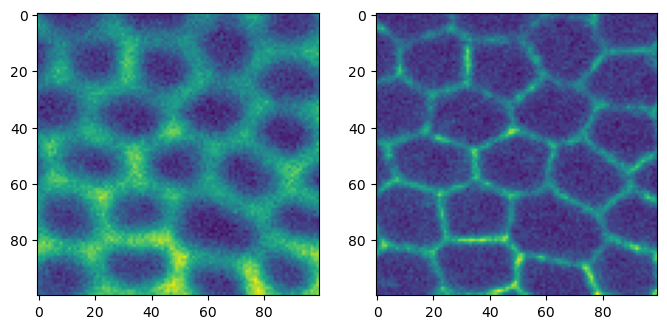

In [4]:
_,ax = plt.subplots(figsize=(8,4),ncols=2)
ax[0].imshow(convolvedGT[0][100:200,100:200])
ax[1].imshow(X_test[0][100:200,100:200])

### Load the Network
Ensure that ```dataName``` is set same as in ```Convallaria-Training.ipynb```.

In [5]:
# ! ls /home/ubuntu/ashesh/data/Flywing/Flywing_n10/train/best*

In [6]:
# Load the network, created in the 'Convallaria-Training.ipynb' notebook
net = torch.load(f"/home/ubuntu/ashesh/training/deconoising/2305/N2V_N5_3.0-4.0/5/best_model.net")

### Evaluation

In [7]:
index = 1
im = convolvedGT[index]
deconvolvedResult, denoisedResult = prediction.tiledPredict(im, net[0] ,ps=256, 
                                                            overlap=48, 
                                                            device=device,
                                                            psf_list=psf_tensor_list)

In [8]:
deconvolvedResult.shape

(512, 512)

308 369 64


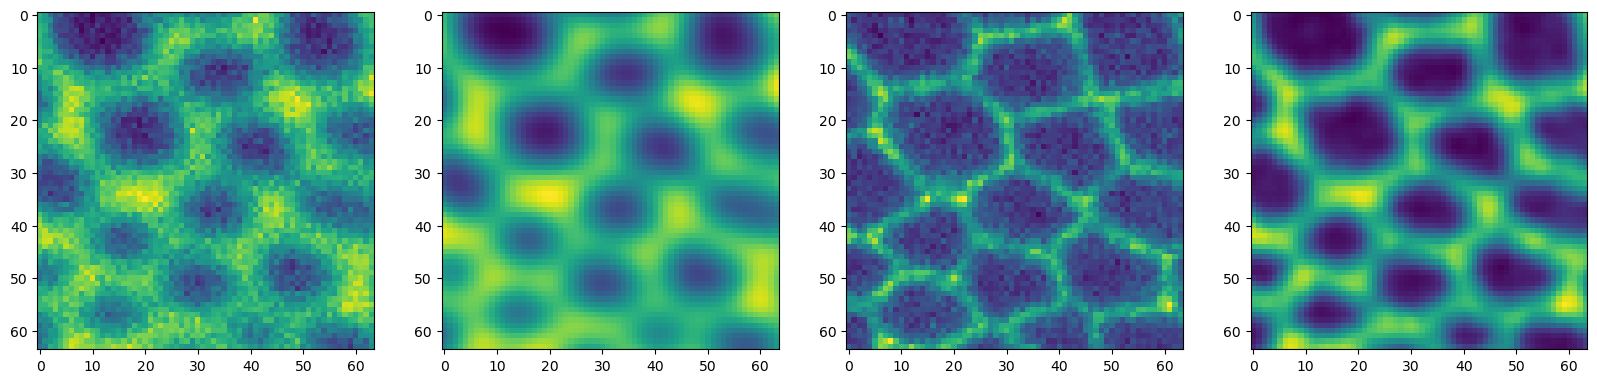

In [9]:
crop_sz = 64
h = np.random.randint(im.shape[0] - crop_sz)
w = np.random.randint(im.shape[1] - crop_sz)
print(h,w,crop_sz)
_,ax = plt.subplots(figsize=(20,5),ncols=4)
ax[0].imshow(im[h:h+crop_sz,w:w+crop_sz])
if denoisedResult is not None:
    ax[1].imshow(denoisedResult[h:h+crop_sz,w:w+crop_sz])

ax[2].imshow(noisyGT[index][h:h+crop_sz,w:w+crop_sz])
ax[3].imshow(deconvolvedResult[h:h+crop_sz,w:w+crop_sz])

In [10]:
# Now we are processing data and calculating PSNR values.

psnr_input = []
psnrNoisyGT_denoised_prediction = []
psnrNoisyGT_denoised_deconvolved_prediction = []
psnrConvolvedGT_denoised_prediction = []
psnrConvolvedGT_denoised_deconvolved_prediction = []

# We iterate over all test images.
for index in range(convolvedGT.shape[0]):
    
    im = convolvedGT[index]
    
    # We are using tiling to fit the image into memory
    # If you get an error try a smaller patch size (ps)
    # Here we are predicting the deconvolved and denoised image
    deconvolvedResult, denoisedResult = prediction.tiledPredict(im, net[0] ,ps=256, overlap=48, device=device,
                                                                psf_list=psf_tensor_list)
    
    # calculate PSNR
    gt = noisyGT[index]
    rangePSNR = np.max(gt) - np.min(gt)
    psnr_input.append(PSNR(gt, im, rangePSNR)) 


    if denoisedResult is not None:
        psnrNoisyGT_denoised_prediction.append(PSNR(gt, denoisedResult, rangePSNR))
    psnrNoisyGT_denoised_deconvolved_prediction.append(PSNR(gt, deconvolvedResult, rangePSNR))
    
    gt = convolvedGT[index]
    rangePSNR = np.max(gt) - np.min(gt)
    if denoisedResult is not None:
        psnrConvolvedGT_denoised_prediction.append(PSNR(gt, denoisedResult, rangePSNR))
    psnrConvolvedGT_denoised_deconvolved_prediction.append(PSNR(gt, deconvolvedResult, rangePSNR))


print("Avg PSNR input:", np.mean(np.array(psnr_input)).round(2),  '+-(2SEM)', (2*np.std(np.array(psnr_input))/np.sqrt(float(len(psnr_input)))).round(2))
if denoisedResult is not None:
    print("[NoisyGT]: Avg PSNR denoised", np.mean(np.array(psnrNoisyGT_denoised_prediction)).round(2),  
          '+-(2SEM)', (2*np.std(np.array(psnrNoisyGT_denoised_prediction))/np.sqrt(float(len(psnrNoisyGT_denoised_prediction)))).round(2))
print("[NoisyGT]: Avg PSNR denoised & deconvolved", np.mean(np.array(psnrNoisyGT_denoised_deconvolved_prediction)).round(2),  
      '+-(2SEM)', (2*np.std(np.array(psnrNoisyGT_denoised_deconvolved_prediction))/np.sqrt(float(len(psnrNoisyGT_denoised_deconvolved_prediction)))).round(2))

if denoisedResult is not None:
    print("[ConvolvedGT]: Avg PSNR denoised", np.mean(np.array(psnrConvolvedGT_denoised_prediction)).round(2),  
          '+-(2SEM)', (2*np.std(np.array(psnrConvolvedGT_denoised_prediction))/np.sqrt(float(len(psnrConvolvedGT_denoised_prediction)))).round(2))
print("[ConvolvedGT]: Avg PSNR denoised & deconvolved", np.mean(np.array(psnrConvolvedGT_denoised_deconvolved_prediction)).round(2),  
      '+-(2SEM)', (2*np.std(np.array(psnrConvolvedGT_denoised_deconvolved_prediction))/np.sqrt(float(len(psnrConvolvedGT_denoised_deconvolved_prediction)))).round(2))

Avg PSNR input: 21.52 +-(2SEM) 0.25
[NoisyGT]: Avg PSNR denoised 21.11 +-(2SEM) 0.25
[NoisyGT]: Avg PSNR denoised & deconvolved 24.02 +-(2SEM) 0.24
[ConvolvedGT]: Avg PSNR denoised 34.16 +-(2SEM) 0.05
[ConvolvedGT]: Avg PSNR denoised & deconvolved 26.73 +-(2SEM) 0.19


In [11]:
! cat /home/ubuntu/ashesh/training/deconoising/2304/N2V_N5_3.0-5.0/6/log.out | grep tensor\( | awk -F "," '{print $1}'| awk -F "(" '{print $2}' > temp.txt 

cat: /home/ubuntu/ashesh/training/deconoising/2304/N2V_N5_3.0-5.0/6/log.out: No such file or directory


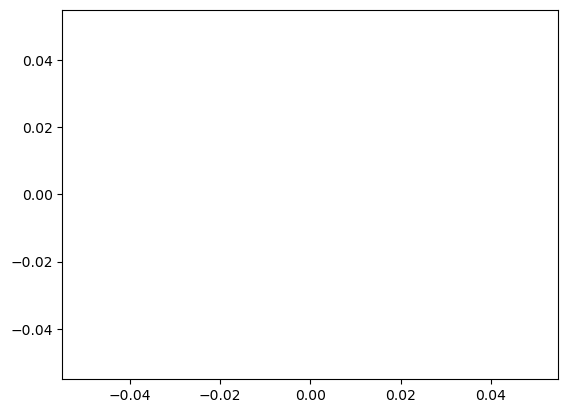

In [12]:
import numpy as np
plt.plot(np.loadtxt('temp.txt'))

Text(0.5, 1.0, 'Denoised output')

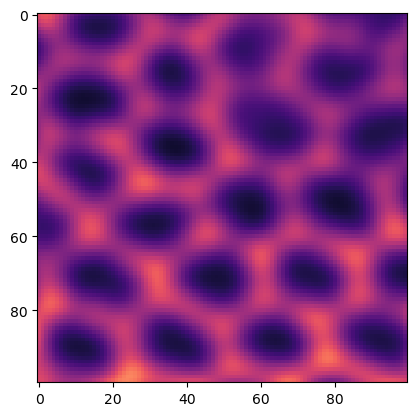

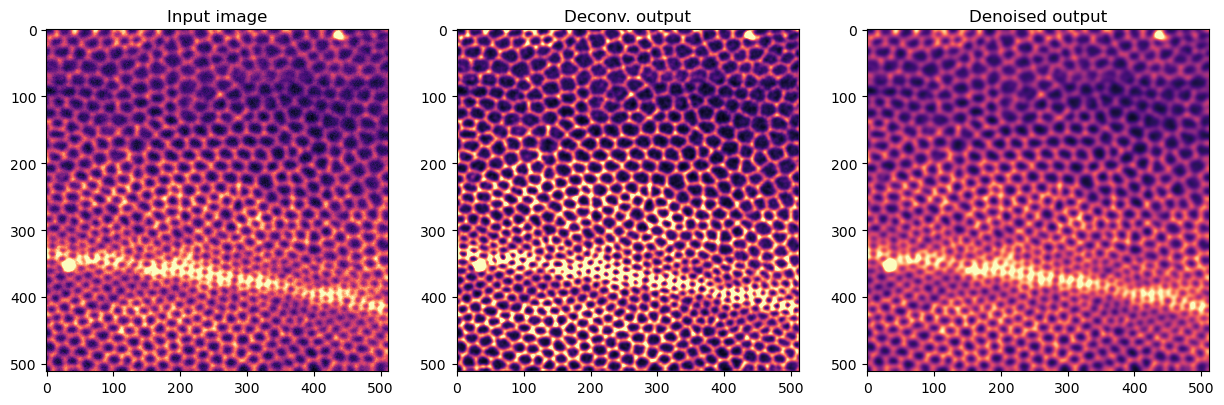

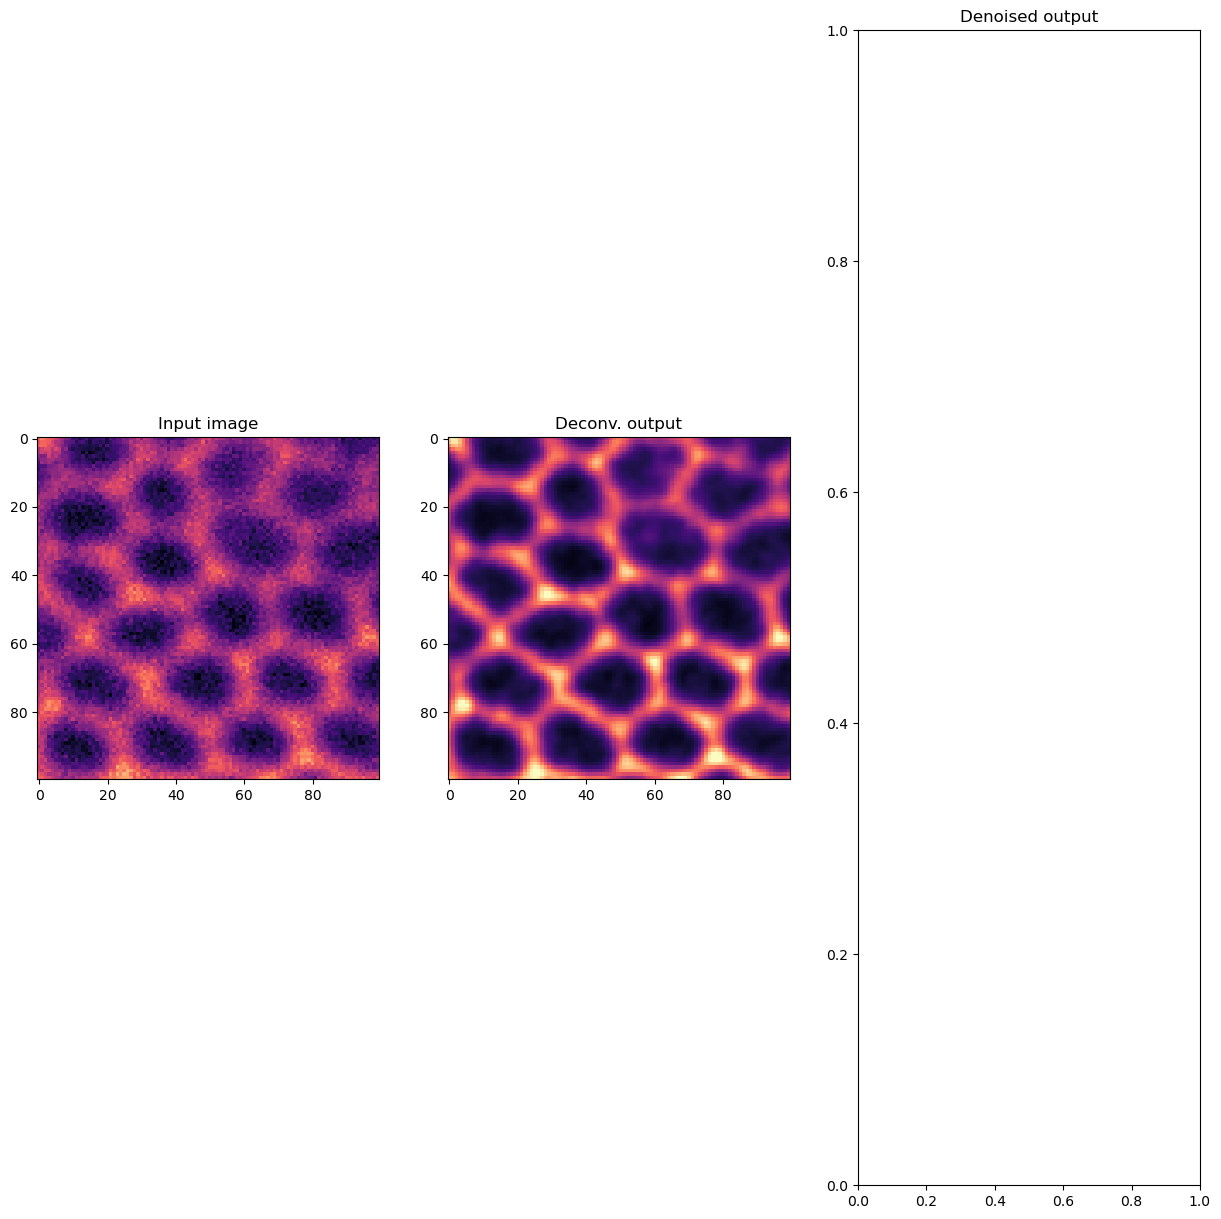

In [13]:
# We display the results for the last test image       
vmi=np.percentile(gt,0.01)
vma=np.percentile(gt,99)

if denoisedResult is not None:
    plt.imshow(denoisedResult[100:200,150:250], vmax=vma, vmin=vmi, cmap='magma')


plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.title('Input image')
plt.imshow(im, vmax=vma, vmin=vmi, cmap='magma')

plt.subplot(1, 3, 2)
plt.title('Deconv. output')
plt.imshow(deconvolvedResult, vmax=vma, vmin=vmi, cmap='magma')


plt.subplot(1, 3, 3)
plt.title('Denoised output')
if denoisedResult is not None:
    plt.imshow(denoisedResult, vmax=vma, vmin=vmi, cmap='magma')

plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.title('Input image')
plt.imshow(im[100:200,150:250], vmax=vma, vmin=vmi, cmap='magma')

plt.subplot(1, 3, 2)
plt.title('Deconv. output')
plt.imshow(deconvolvedResult[100:200,150:250], vmax=vma, vmin=vmi, cmap='magma')

plt.subplot(1, 3, 3)
plt.title('Denoised output')

In [14]:
break here

SyntaxError: invalid syntax (760050616.py, line 1)

## Learnable Gaussian Layer
The model is able to come to the correct PSF.

In [ ]:
from deconoising.learnable_gaussian_blur import GaussianLayer
import torch.nn as nn

gblur = GaussianLayer(1,21,pad_type='reflect',std=10)

index = 0
inp = noisyGT[index][100:164,100:164].copy()
tar = convolvedGT[index][100:164,100:164].copy()

inp = torch.Tensor(inp[None,None])
tar = torch.Tensor(tar[None,None])

with torch.no_grad():
    out = gblur(inp).cpu().numpy()

_,ax = plt.subplots(figsize=(12,4),ncols=3)
ax[0].imshow(inp[0,0])
ax[1].imshow(out[0,0])
ax[2].imshow(tar[0,0])

In [ ]:
optimizer = torch.optim.Adam(gblur.parameters(), lr=0.1)
for _ in range(100):
    optimizer.zero_grad()
    out = gblur(inp)
    loss = nn.MSELoss()(out[0,0], tar)
    loss.backward()
    optimizer.step()
    print(f"{loss.item():.2f} {gblur.std.item():.2f}")